In [20]:
from glob import glob
import os,sys
import xarray as xr
import cartopy.crs as ccrs
from cartopy import feature

import matplotlib.pyplot as plt
%matplotlib widget
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sea_clearly.output_refinery import output_refinery_nearby
from sea_clearly.create_masks import get_coastal_nodes
from sea_clearly import settings

class postprocess:
    
    def __init__(self,settings,str_fwd,str_bwd):
        self.files_fwd = sorted(glob(os.path.join(settings.DIR_OUTPUT,str_fwd)))
        self.files_bwd = sorted(glob(os.path.join(settings.DIR_OUTPUT,str_bwd)))
        self.land_mask = xr.load_dataset(os.path.join(settings.DIR_INPUT,settings.NAME_LANDMASK))
        
        if len(self.files_fwd) == 0:
            print('No forwards run files found, forwards analysis will not work')
        if len(self.files_bwd) == 0:
            print('No backwards run files found, backwards analysis will not work')
            
    def refine(self,lon_refine,lat_refine,dlon=0.1,dlat=0.1,mode='fwd'):
        if mode == 'fwd':
            files = self.files_fwd
        elif mode == 'bwd':
            files = self.files_bwd
            
        for i1,file in enumerate(files):
            data = xr.open_zarr(file)
            if i1==0:
                data_refined = output_refinery_nearby(data,lon_refine,lat_refine,dlon=dlon/2,dlat=dlat/2)
            else:
                #TODO: raise error here if the concatination fails
                data_concat = output_refinery_nearby(data,lon_refine,lat_refine,dlon=dlon/2,dlat=dlat/2)
                data_refined = xr.concat([data_refined,data_concat],dim='traj')
        self.data_refined = data_refined
        self.n_release = len(files)
        
    def set_analysis_grids(self,dlon_coarse,dlat_coarse):
        X_land,Y_land = np.meshgrid(self.land_mask['lon'],self.land_mask['lat'])

        x_land_coarse = np.arange(self.land_mask['lon'].min(),self.land_mask['lon'].max()+dlon_coarse,dlon_coarse)
        y_land_coarse = np.arange(self.land_mask['lat'].min(),self.land_mask['lat'].max()+dlat_coarse,dlat_coarse)
        bins_x_land_coarse = np.insert( .5*(x_land_coarse[1:] + x_land_coarse[:-1]),[0,len(x_land_coarse)-1],[x_land_coarse[0]-.5*dlon_coarse,x_land_coarse[-1]+.5*dlon_coarse])
        bins_y_land_coarse = np.insert( .5*(y_land_coarse[1:] + y_land_coarse[:-1]),[0,len(y_land_coarse)-1],[y_land_coarse[0]-.5*dlat_coarse,y_land_coarse[-1]+.5*dlat_coarse])

        X_land_coarse,Y_land_coarse = np.meshgrid(x_land_coarse,y_land_coarse)
        self.analysis_landmask = griddata((X_land.ravel(),Y_land.ravel()),self.land_mask['mask_land'].values.ravel(),(X_land_coarse,Y_land_coarse),method='nearest')
        self.analysis_coastmask = get_coastal_nodes(self.analysis_landmask)
        self.analysis_X = X_land_coarse
        self.analysis_Y = Y_land_coarse
        self.analysis_bins_x = bins_x_land_coarse
        self.analysis_bins_y = bins_y_land_coarse
        self.X_pmesh,self.Y_pmesh = np.meshgrid(bins_x_land_coarse,bins_y_land_coarse)
        self.analysis_dlon = dlon_coarse
        self.analysis_dlat = dlat_coarse
        
    def calculate_likelihood(self,lon_refine,lat_refine,dlon=0.1,dlat=0.1,mode='fwd'):
        self.refine(lon_refine,lat_refine,dlon=dlon,dlat=dlat,mode=mode)
        
        hist = np.histogram2d(self.data_refined['lon'].values.ravel(),self.data_refined['lat'].values.ravel(),
                              bins=[self.analysis_bins_x,self.analysis_bins_y])[0].T
        
        ratio_analysis_release = (self.analysis_dlon*self.analysis_dlat) / (dlon*dlat)
        self.likelihood = (hist/hist.sum()) * (len(results.data_refined['obs']) / self.n_release) * ratio_analysis_release
        # self.likelihood = hist * ratio_analysis_release
        self.analysis_area_m2 = self.analysis_dlon*1.11e5 * (self.analysis_dlat*1.11e5*np.cos(lat_refine*(np.pi/180)))

        
    def calculate_priors(self,in_tot_coast=1525,in_tot_rivers=800): #in tonnes per year (see Kaandorp 2020)
        tyr_to_kgd = 1000/365
        
        input_coasts = xr.load_dataset('../data/coastal_MPW_input.nc')
        input_rivers = xr.load_dataset('../data/riverine_input.nc')

        X_coast,Y_coast = np.meshgrid(input_coasts['lon'],input_coasts['lat'])
        X_riv,Y_riv = np.meshgrid(input_rivers['lon'],input_rivers['lat'])

        mask_coast_coarse = self.analysis_coastmask == 1
        mask_input_coast = input_coasts['MPW'] > 0
        mask_input_rivers = input_rivers['input_rivers'] > 0
        
        vals_coast_coarse = griddata((X_coast[mask_input_coast],Y_coast[mask_input_coast]),
                                       input_coasts['MPW'].values[mask_input_coast],
                                       (self.analysis_X[mask_coast_coarse],self.analysis_Y[mask_coast_coarse]),method='nearest')
        
        vals_rivers_coarse = griddata((X_coast[mask_input_rivers],Y_coast[mask_input_rivers]),
                                       input_rivers['input_rivers'].values[mask_input_rivers],
                                       (self.analysis_X[mask_coast_coarse],self.analysis_Y[mask_coast_coarse]),method='nearest')
                
        self.input_coast = np.zeros(self.analysis_landmask.shape)
        self.input_coast[mask_coast_coarse] = vals_coast_coarse
        self.input_coast *= (in_tot_coast/self.input_coast.sum())*tyr_to_kgd
        
        self.input_rivers = np.zeros(self.analysis_landmask.shape)
        self.input_rivers[mask_coast_coarse] = vals_rivers_coarse
        self.input_rivers *= (in_tot_rivers/self.input_rivers.sum())*tyr_to_kgd  
        
        self.input_total = self.input_coast + self.input_rivers
        
        
    def calculate_posterior(self):
        self.posterior = self.likelihood * self.input_total
        self.concentration_g_m2 = (self.posterior.sum()*1000) / self.analysis_area_m2
          
    #method that can be used to sort results by time, which can be nice for animations but not used at the moment
    # at the moment, all release times are release at once
    def sort_results_by_time(self): 
        sim_fwd = results.data_refined['time'][0,1].values > results.data_refined['time'][0,0].values
        t_min = results.data_refined['time'].values.min()
        t_max = results.data_refined['time'].values.max()
        times_plot = pd.date_range(t_min,t_max,freq='D')
        if not sim_fwd:
            times_plot = times_plot[::-1]

        data_processed = {}
        for time_ in times_plot:
            data_processed[time_] = {}

            mask = (results.data_refined['time'] == time_).values
            data_processed[time_]['lons'] = results.data_refined['lon'].values[mask]
            data_processed[time_]['lats'] = results.data_refined['lat'].values[mask]

    def set_figure(self,xlim=(-6,36.5),ylim=(30,46),background_map='mesh'):
        self.fig = plt.figure(figsize=(14,4.5))
        gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[30,1])
        
        self.ax = self.fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree()) #plot with the map
        self.cax = self.fig.add_subplot(gs[0,1]) #plot with the colorbar
        self.cax.axis('off') #hide colorbar for now
    
        if background_map == 'mesh':
            self.ax.pcolormesh(self.analysis_X, self.analysis_Y, self.analysis_landmask[:-1,:-1],cmap='Greys',alpha=1.,vmin=0,vmax=2,zorder=0)
        else:
            self.ax.add_feature(feature.NaturalEarthFeature('physical','land','50m'),facecolor='lightgrey',zorder=0)

        self.ax.set_xlim(xlim[0],xlim[1])
        self.ax.set_ylim(ylim[0],ylim[1])
    
#     def update_fig_title(self,str_,**kwargs):
#         if self.title:
#             # self.title.set_text('')
#             self.title.set_text(str_,**kwargs)
#         else:
#             self.title = self.ax.set_title(str_,**kwargs)
#         self.fig.canvas.draw()
        
    def update_fig_title(self,str_,**kwargs):
        # self.fig.canvas.draw()
        rect = patches.Rectangle((0.0,1.01), 1., .12, linewidth=1, edgecolor=None, facecolor='w',transform=self.ax.transAxes, clip_on=False)
        self.ax.add_patch(rect)
        # self.fig.canvas.draw()
        if self.title:
            # self.title.set_text('')
            self.title.set_text(str_)
        else:
            self.title = self.ax.text(0.5,1.05, str_, bbox={'facecolor':'w', 'alpha':0.8, 'pad':5},
                                        transform=self.ax.transAxes, ha="center")
        self.fig.canvas.draw()        
        
        
    def animate_particles(self,framedt=100):

        self.data_refined = self.data_refined.load()
        # self.update_fig_title('Live integration of particle trajectories...')
        plt.pause(.5)
        self.points, = self.ax.plot([], [], 'o',markersize=2,zorder=1)     
        def animate(frame_num):
            self.points.set_data(( self.data_refined['lon'][:,frame_num],self.data_refined['lat'][:,frame_num]))
            
            if frame_num > n_start_opaque:
                n_opaque_frames = n_frames - n_start_opaque
                i_from_start = frame_num - n_start_opaque
                alpha_ = 1-(i_from_start/n_opaque_frames)
                if alpha_ > 0.:
                    self.points.set_alpha(alpha_)
           
            if frame_num == n_frames-1:
                self.update_fig_title('Animation done, click for resulting analysis')
                self.fig.canvas.draw() 
                plt.show(block=True)
                
            return self.points
        
        n_frames = len(self.data_refined['obs'])-1
        n_start_opaque = n_frames - 10
        anim = FuncAnimation(self.fig, animate, frames=len(self.data_refined['obs'])-1, interval=framedt, repeat=False, blit=True)
        return anim
    
    def backwards_animate(self,dlon_analysis,dlat_analysis,framedt=100,background_map='mesh'):
        # format log-scale colorbars
        def fmt(x, pos):
            float_ = 10**float(x)
            return r'%4.4f'%float_
     
        self.set_analysis_grids(dlon_analysis,dlat_analysis)
        if background_map == 'mesh':
            self.set_figure(background_map=background_map)
        else:
            self.set_figure(background_map=background_map,xlim=(-6,38.5),ylim=(29.5,47))
            self.assign_country_to_coastline()
        self.title = None
        reset_plot = False
        pos = []
        clicks = []

        def onclick(event):
            pos = [event.xdata,event.ydata]
            clicks.append(1)

            if len(clicks) == 1:
                self.pos_analysis = pos
                self.ax.plot(self.pos_analysis[0],self.pos_analysis[1],'kx',markersize=14,zorder=3)
                self.update_fig_title('Calculating particle statistics...')
                self.calculate_likelihood(pos[0],pos[1],dlon=dlon_analysis,dlat=dlat_analysis,mode='bwd')

                self.calculate_priors()
                self.calculate_posterior()
                
                self.update_fig_title('Requesting big data & live integration (can take some time)...')
                global animation
                animation = self.animate_particles(framedt=framedt)                
                animation.event_source.stop()
                
            elif len(clicks) == 2:
                likelihood_plot = self.likelihood.copy()
                likelihood_plot[likelihood_plot == 0] = np.nan
                likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages
                int_min = int(np.floor(np.nanmin(np.log10(likelihood_plot))))
                int_max = int(np.ceil(np.nanmax(np.log10(likelihood_plot))))
                ticks = np.arange(int_min,int_max+1,1)
                self.plt_lik = self.ax.pcolormesh(self.analysis_X, self.analysis_Y, np.log10(likelihood_plot[:-1,:-1]),cmap=plt.cm.viridis,alpha=.7,zorder=2)
                self.cax.axis('on')
                cbar=self.fig.colorbar(self.plt_lik,cax=self.cax,ticks=ticks,format=ticker.FuncFormatter(fmt))
                cbar.set_label('Backtracking histogram [%]', rotation=90)
                self.update_fig_title('Click for posterior pdf (litter sources)...')
                plt.show(block=True)
                
            elif len(clicks) == 3:
                self.points.set_alpha(0.0)
                if background_map=='mesh':
                    posterior_plot = self.posterior.copy()
                    posterior_plot[posterior_plot==0] = np.nan
                    posterior_plot = posterior_plot * (100/np.nansum(posterior_plot)) # convert to percentages
                    int_min = int(np.floor(np.nanmin(np.log10(posterior_plot))))
                    int_max = int(np.ceil(np.nanmax(np.log10(posterior_plot))))
                    ticks = np.arange(int_min,int_max+1,1)
                    
                    self.plt_lik.remove()
                    self.plt_post = self.ax.pcolormesh(self.analysis_X, self.analysis_Y, np.log10(posterior_plot[:-1,:-1]),cmap=plt.cm.viridis,alpha=1.,zorder=2)
                    cbar=self.fig.colorbar(self.plt_post,cax=self.cax,ticks=ticks,format=ticker.FuncFormatter(fmt))
                    cbar.set_label('Pollution origin [%]', rotation=90)
                    self.update_fig_title('Estimated concentration: %.2e g/m2' % self.concentration_g_m2)
                    plt.show(block=True)
                else:
                    self.plt_lik.set_alpha(0.4)
                    self.ax.add_feature(feature.BORDERS,color='silver',linewidth=0.8)
                    sizes = []
                    vals = []
                    lons = []
                    lats = []
                    use = np.zeros(len(self.countries_positions.keys()))
                    for i1,key_ in enumerate(self.countries_positions.keys()):
                        mask_country = self.country_coast == i1
                        if self.posterior[mask_country].sum() > 0:
                            use[i1] = 1
                            vals.append(self.posterior[mask_country].sum())
                            lons.append(self.countries_positions[key_][0])
                            lats.append(self.countries_positions[key_][1])
                            self.ax.text(self.countries_positions[key_][0]-.7,self.countries_positions[key_][1]+.7,key_)
                    vals = np.array(vals)
                    vals *= (100/vals.sum() )
                    minsize = 10
                    maxsize = 200
                    sizes = minsize + maxsize*(vals/100)
                    colors = np.array([plt.cm.viridis(val_) for val_ in (vals/100)])
                    self.plt_countries = self.ax.scatter(lons,lats,s=sizes,c=vals,cmap=plt.cm.viridis)
                    self.cax.axis('on')
                    cbar=self.fig.colorbar(self.plt_countries,cax=self.cax)#,format=ticker.FuncFormatter(fmt))
                    cbar.set_label('Country contributions [%]', rotation=90)
                    self.update_fig_title('Estimated concentration: %.2e g/m2' % self.concentration_g_m2)
                    plt.show(block=True)
            elif len(clicks) == 4:
                self.fig.canvas.mpl_disconnect(cid)
                reset_plot = True
                # stop_plotting = True
             
        cid = self.fig.canvas.mpl_connect('button_press_event', onclick)

    def calculate_MPAs(self):
        MPA = xr.load_dataset('../data/MPA_field.nc')
        X_mpa,Y_mpa= np.meshgrid(MPA['lon'],MPA['lat'])
        
        mask_ocean = self.analysis_landmask == 0
        
        MPA_coarse = griddata((X_mpa.ravel(),Y_mpa.ravel()),
                               MPA['MPA_field'].values.ravel(),
                               (self.analysis_X[mask_ocean],self.analysis_Y[mask_ocean]),method='nearest')
        
        self.MPA = np.zeros(self.analysis_landmask.shape)
        self.MPA[mask_ocean] = MPA_coarse
        
    def assign_country_to_coastline(self):
        data_countries = xr.load_dataset('../data/coastal_countries.nc')

        X_,Y_ = np.meshgrid(data_countries['lon'],data_countries['lat'])

        mask_coast_coarse = self.analysis_coastmask == 1
        mask_input_coast = ~np.isnan(data_countries['coast_country'])

        vals_coast_coarse = griddata((X_[mask_input_coast],Y_[mask_input_coast]),
                                       data_countries['coast_country'].values[mask_input_coast],
                                       (self.analysis_X[mask_coast_coarse],self.analysis_Y[mask_coast_coarse]),method='nearest')

        self.country_coast = np.zeros(self.analysis_landmask.shape)
        self.country_coast[mask_coast_coarse] = vals_coast_coarse

        #TODO: this is not generalizable at the moment, something to do in the future
        self.countries_positions = {'Albania':[20,41], 'Algeria':[4,35], 'Bosnia and Herzegovina':[17.3,43.7], 'Croatia':[16.7,45.5],
               'Cyprus':[33,35], 'Egypt':[30,31], 'France':[3,44], 'Greece':[22,38], 'Israel':[35.5,32.5], 'Italy':[13,42],
               'Lebanon':[35.8,34.4], 'Libya':[17.2,30.8], 'Montenegro':[19,42.5], 'Morocco':[-4.5,33.5], 'Northern Cyprus':[0,0],
               'Palestine':[34,30.5], 'Slovenia':[13.5,45.5], 'Spain':[-3,39], 'Syria':[36,36], 'Tunisia':[9.5,35], 'Turkey':[30,37.5]}


    def forwards_analysis(self,dlon_analysis,dlat_analysis,pos,background_map='mesh'):
        # format log-scale colorbars
        def fmt(x, pos):
            float_ = 10**float(x)
            return r'%4.4f'%float_
     
        self.set_analysis_grids(dlon_analysis,dlat_analysis)
        self.calculate_MPAs()
        self.set_figure(background_map=background_map)
        self.title = None
        
        self.ax.plot(pos[0],pos[1],'kx',markersize=14,zorder=3)
        self.calculate_likelihood(pos[0],pos[1],dlon=dlon_analysis,dlat=dlat_analysis,mode='fwd')

        likelihood_plot = self.likelihood.copy()
        likelihood_plot[likelihood_plot == 0] = np.nan
        likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages
        int_min = int(np.floor(np.nanmin(np.log10(likelihood_plot))))
        int_max = int(np.ceil(np.nanmax(np.log10(likelihood_plot))))
        ticks = np.arange(int_min,int_max+1,1)
        self.plt_lik = self.ax.pcolormesh(self.analysis_X, self.analysis_Y, np.log10(likelihood_plot[:-1,:-1]),cmap=plt.cm.viridis,alpha=.7,zorder=2)
        self.cax.axis('on')
        cbar=self.fig.colorbar(self.plt_lik,cax=self.cax,ticks=ticks,format=ticker.FuncFormatter(fmt))
        cbar.set_label('Forward run histogram [%]', rotation=90)
        
        self.calculate_MPAs()
        MPA_true = self.MPA.copy()
        MPA_true[MPA_true > 0] = 1

        likelihood_plot = self.likelihood.copy()
        likelihood_plot[likelihood_plot == 0] = np.nan
        likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages

        MPA_overlapping = (MPA_true.astype(bool) * (self.likelihood > 0)).astype(float)
        MPA_overlapping[MPA_overlapping == 0] = np.nan

        overlap = likelihood_plot * MPA_true
        self.overlap_percent = np.nansum(overlap)

        self.ax.contourf(self.analysis_X, self.analysis_Y, MPA_overlapping,levels=np.array([0,1]),cmap=plt.cm.Reds,hatches=['\\'*6],linestyles='solid',alpha=.8,zorder=3,vmin=0,vmax=1)
        self.ax.set_title('Overlap with Marine Protected Areas: %2.2f%%' % self.overlap_percent)


    def forwards_animate(self,dlon_analysis,dlat_analysis,framedt=100,background_map='mesh'):
        # format log-scale colorbars
        def fmt(x, pos):
            float_ = 10**float(x)
            return r'%4.4f'%float_
     
        self.set_analysis_grids(dlon_analysis,dlat_analysis)
        self.set_figure(background_map=background_map)
        self.title = None
        
        reset_plot = False
        pos = []
        clicks = []

        def onclick(event):
            pos = [event.xdata,event.ydata]
            clicks.append(1)

            if len(clicks) == 1:
                self.pos_analysis = pos
                self.ax.plot(self.pos_analysis[0],self.pos_analysis[1],'kx',markersize=14,zorder=3)
                self.update_fig_title('Calculating particle statistics...')
                self.calculate_likelihood(pos[0],pos[1],dlon=dlon_analysis,dlat=dlat_analysis,mode='fwd')

                self.update_fig_title('Requesting big data & live integration (can take some time)...')
                global animation
                animation = self.animate_particles(framedt=framedt)
                animation.event_source.stop()
                # self.update_fig_title('Click for particle histogram')
                
            elif len(clicks) == 2:
                likelihood_plot = self.likelihood.copy()
                likelihood_plot[likelihood_plot == 0] = np.nan
                likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages
                int_min = int(np.floor(np.nanmin(np.log10(likelihood_plot))))
                int_max = int(np.ceil(np.nanmax(np.log10(likelihood_plot))))
                ticks = np.arange(int_min,int_max+1,1)
                self.plt_lik = self.ax.pcolormesh(self.analysis_X, self.analysis_Y, np.log10(likelihood_plot[:-1,:-1]),cmap=plt.cm.viridis,alpha=.7,zorder=2)
                self.cax.axis('on')
                cbar=self.fig.colorbar(self.plt_lik,cax=self.cax,ticks=ticks,format=ticker.FuncFormatter(fmt))
                cbar.set_label('Forward run histogram [%]', rotation=90)
                self.update_fig_title('Click for overlapping Marine Protected Areas...')
                plt.show(block=True)
          
            elif len(clicks) == 3:
                self.calculate_MPAs()
                MPA_true = self.MPA.copy()
                MPA_true[MPA_true > 0] = 1

                likelihood_plot = self.likelihood.copy()
                likelihood_plot[likelihood_plot == 0] = np.nan
                likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages
        
                MPA_overlapping = (MPA_true.astype(bool) * (self.likelihood > 0)).astype(float)
                MPA_overlapping[MPA_overlapping == 0] = np.nan


                overlap = likelihood_plot * MPA_true
                self.overlap_percent = np.nansum(overlap)

                self.ax.contourf(self.analysis_X, self.analysis_Y, MPA_overlapping,levels=np.array([0,1]),cmap=plt.cm.Reds,hatches=['\\'*6],linestyles='solid',alpha=.8,zorder=3,vmin=0,vmax=1)
                self.update_fig_title('Overlap with Marine Protected Areas: %2.2f%%' % self.overlap_percent)
                plt.show(block=True)
                
        cid = self.fig.canvas.mpl_connect('button_press_event', onclick)

In [23]:
dlon_analysis = 0.2 #analysis grid resolution
dlat_analysis = 0.2
# dlon_refine = 0.1 #particle release area dimensions. Can be set same as analysis grid res, but not necessary
# dlat_refine = 0.1

results = postprocess(settings,'*fwd*2015-0[1-2]*','*bwd*2015-[11-12]*')

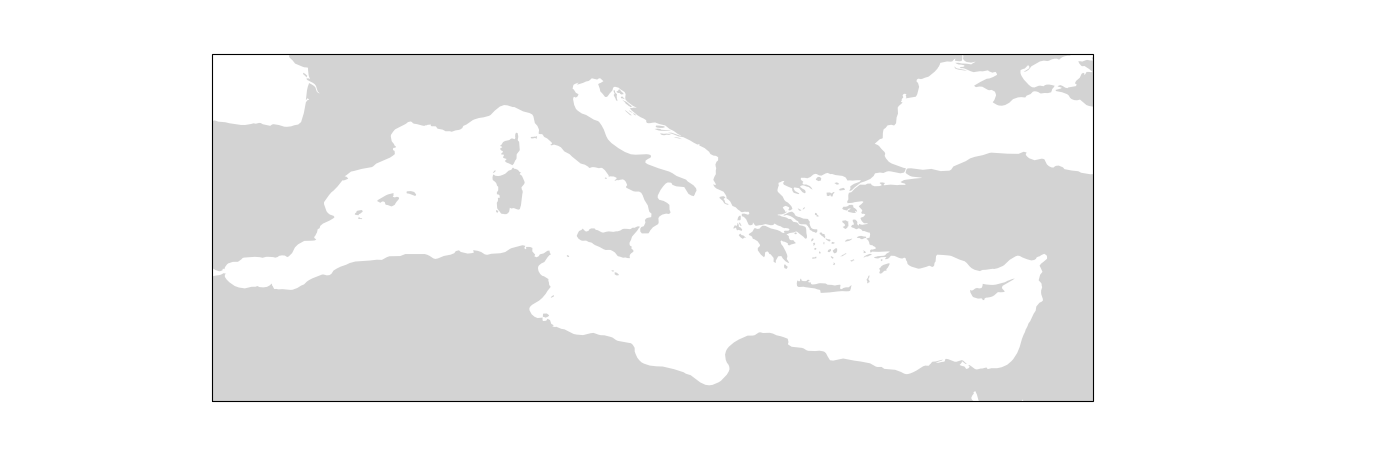

In [24]:
anim = results.backwards_animate(dlon_analysis,dlat_analysis,framedt=50,background_map='map') #background map: 'mesh' or 'map'


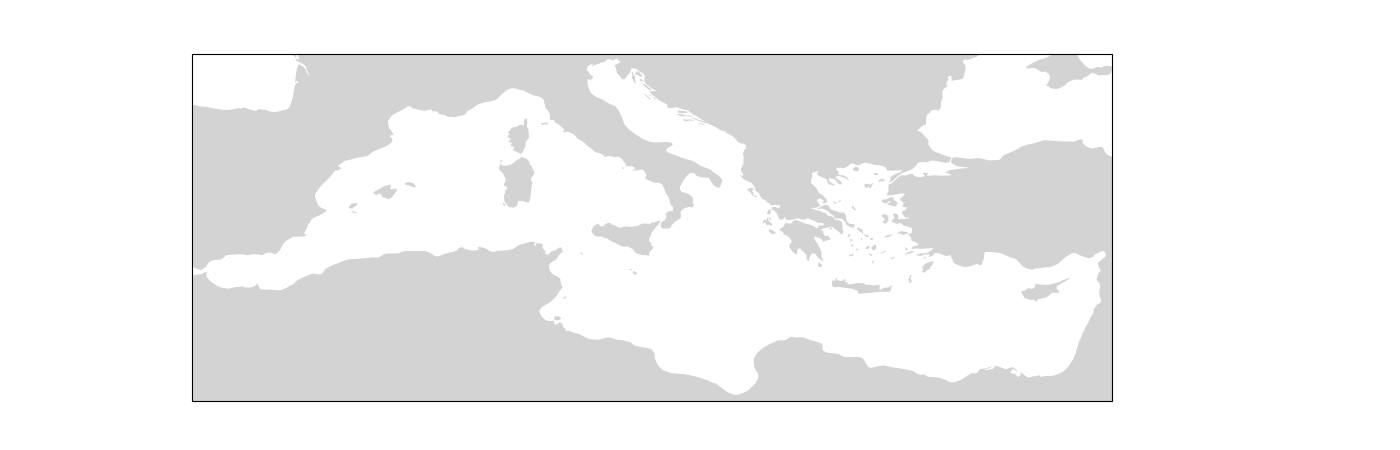

In [13]:
anim = results.forwards_animate(dlon_analysis,dlat_analysis,framedt=50,background_map='map')


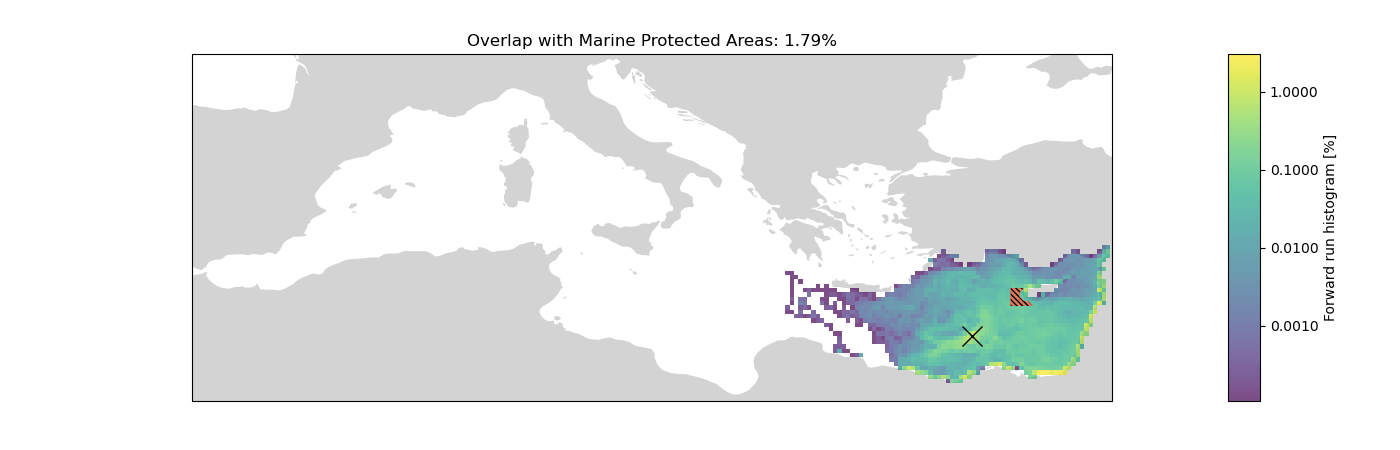

In [4]:
results.forwards_analysis(dlon_analysis,dlat_analysis,(30,33),background_map='map')


In [5]:
results.overlap_percent

1.7894795127353265

In [12]:
results.calculate_MPAs()
MPA_true = results.MPA.copy()
MPA_true[MPA_true > 0] = 1

likelihood_plot = results.likelihood.copy()
likelihood_plot[likelihood_plot == 0] = np.nan
likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages

MPA_overlapping = (MPA_true.astype(bool) * (results.likelihood > 0)).astype(float)
MPA_overlapping[MPA_overlapping == 0] = np.nan

overlap = likelihood_plot * MPA_true
overlap_percent = np.nansum(overlap)

results.ax.contourf(results.analysis_X, results.analysis_Y, MPA_overlapping,levels=np.array([0,1]),cmap=plt.cm.Reds,hatches=['\\'*6],linestyles='solid',alpha=.8,zorder=3,vmin=0,vmax=1)
results.ax.set_title('Overlap with Marine Protected Areas: %2.2f%%' % overlap_percent)


Text(0.5, 1.0, 'Overlap with Marine Protected Areas: 1.79%')

/nethome/kaand004/.conda/envs/py3_parcels_SC/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


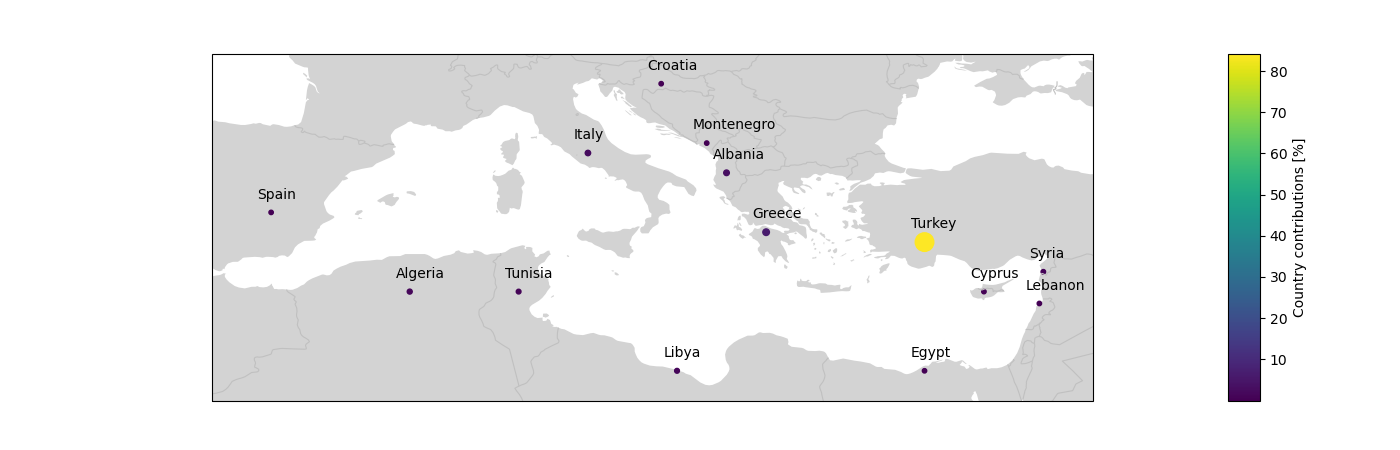

In [36]:
# def map_posterior_to_country():

data_countries = xr.load_dataset('../data/coastal_countries.nc')

X_,Y_ = np.meshgrid(data_countries['lon'],data_countries['lat'])

mask_coast_coarse = results.analysis_coastmask == 1
mask_input_coast = ~np.isnan(data_countries['coast_country'])

vals_coast_coarse = griddata((X_[mask_input_coast],Y_[mask_input_coast]),
                               data_countries['coast_country'].values[mask_input_coast],
                               (results.analysis_X[mask_coast_coarse],results.analysis_Y[mask_coast_coarse]),method='nearest')

results.country_coast = np.zeros(results.analysis_landmask.shape)
results.country_coast[mask_coast_coarse] = vals_coast_coarse

Med_countries = {'Albania':[20,41], 'Algeria':[4,35], 'Bosnia and Herzegovina':[17.3,43.7], 'Croatia':[16.7,45.5],
       'Cyprus':[33,35], 'Egypt':[30,31], 'France':[3,44], 'Greece':[22,38], 'Israel':[35.5,32.5], 'Italy':[13,42],
       'Lebanon':[35.8,34.4], 'Libya':[17.5,31], 'Montenegro':[19,42.5], 'Morocco':[-4.5,33.5], 'Northern Cyprus':[0,0],
       'Palestine':[34,30.5], 'Slovenia':[13.5,45.5], 'Spain':[-3,39], 'Syria':[36,36], 'Tunisia':[9.5,35], 'Turkey':[30,37.5]}


results.set_figure(xlim=(-6,38.5),ylim=(29.5,47),background_map='map')
# # results.ax.set_facecolor(plt.cm.Greys(.5))
results.ax.add_feature(feature.BORDERS,color='silver',linewidth=0.8)
sizes = []
vals = []
lons = []
lats = []
use = np.zeros(len(Med_countries.keys()))
for i1,key_ in enumerate(Med_countries.keys()):
    mask_country = results.country_coast == i1
    if results.posterior[mask_country].sum() > 0:
        use[i1] = 1
        vals.append(results.posterior[mask_country].sum())
        lons.append(Med_countries[key_][0])
        lats.append(Med_countries[key_][1])
        results.ax.text(Med_countries[key_][0]-.7,Med_countries[key_][1]+.7,key_)


vals = np.array(vals)
vals *= (100/vals.sum() )

minsize = 10
maxsize = 200
sizes = minsize + maxsize*(vals/100)
colors = np.array([plt.cm.viridis(val_) for val_ in (vals/100)])

results.plt_countries = results.ax.scatter(lons,lats,s=sizes,c=vals,cmap=plt.cm.viridis)

results.cax.axis('on')
cbar=results.fig.colorbar(results.plt_countries,cax=results.cax)#,format=ticker.FuncFormatter(fmt))
cbar.set_label('Country contributions [%]', rotation=90)


['Albania',
 'Algeria',
 'Bosnia and Herzegovina',
 'Croatia',
 'Cyprus',
 'Egypt',
 'France',
 'Greece',
 'Israel',
 'Italy',
 'Lebanon',
 'Libya',
 'Montenegro',
 'Morocco',
 'Northern Cyprus',
 'Palestine',
 'Slovenia',
 'Spain',
 'Syria',
 'Tunisia',
 'Turkey']

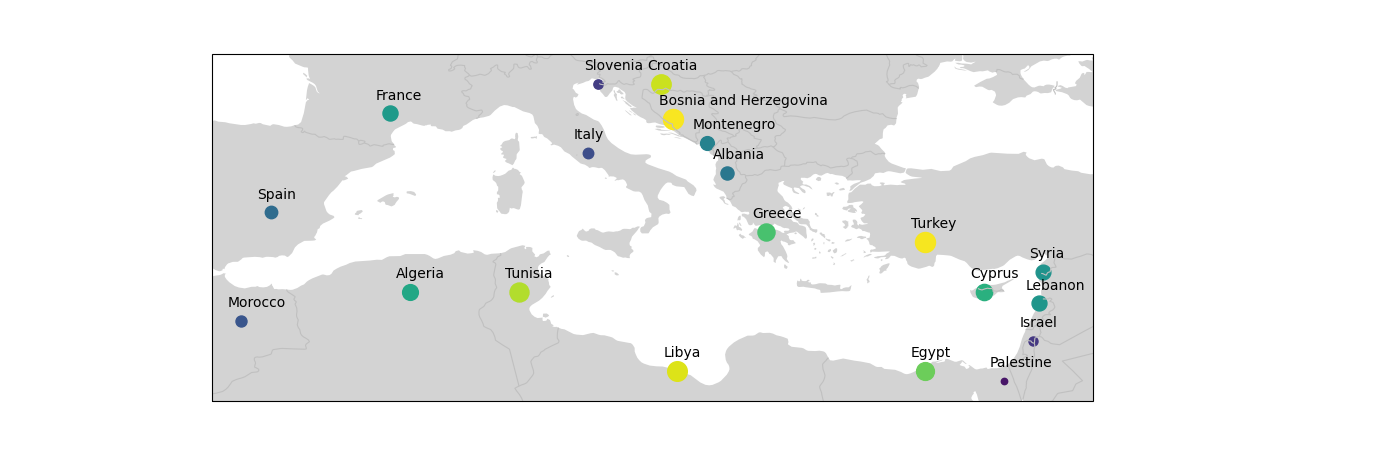

In [21]:
Med_countries = {'Albania':[20,41], 'Algeria':[4,35], 'Bosnia and Herzegovina':[17.3,43.7], 'Croatia':[16.7,45.5],
       'Cyprus':[33,35], 'Egypt':[30,31], 'France':[3,44], 'Greece':[22,38], 'Israel':[35.5,32.5], 'Italy':[13,42],
       'Lebanon':[35.8,34.4], 'Libya':[17.5,31], 'Montenegro':[19,42.5], 'Morocco':[-4.5,33.5], 'Northern Cyprus':[0,0],
       'Palestine':[34,30.5], 'Slovenia':[13.5,45.5], 'Spain':[-3,39], 'Syria':[36,36], 'Tunisia':[9.5,35], 'Turkey':[30,37.5]}


results.set_figure(xlim=(-6,38.5),ylim=(29.5,47),background_map='map')
# results.ax.set_facecolor(plt.cm.Greys(.5))
results.ax.add_feature(feature.BORDERS,color='silver',linewidth=0.8)

for key_ in Med_countries.keys():
    minsize = 10
    maxsize = 200
    val_ = np.random.uniform(0,1)
    size_ = minsize + maxsize*val_
    color_ = plt.cm.viridis(val_)
    results.ax.scatter(Med_countries[key_][0],Med_countries[key_][1],s=size_,c=np.array([color_]))
    results.ax.text(Med_countries[key_][0]-.7,Med_countries[key_][1]+.7,key_)

In [ ]:
likelihood_plot = results.likelihood.copy()
likelihood_plot[likelihood_plot == 0] = np.nan
likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages

MPA_true = results.MPA.copy()
MPA_true[MPA_true > 0] = 1

MPA_overlapping = (MPA_true.astype(bool) * (results.likelihood > 0)).astype(float)
MPA_overlapping[MPA_overlapping == 0] = np.nan


overlap = likelihood_plot * MPA_true
overlap_percent = np.nansum(overlap)

plt.figure()
# plt.pcolormesh(results.analysis_X, results.analysis_Y, MPA_overlapping[:-1,:-1],cmap=plt.cm.Reds,alpha=.8,zorder=3,vmin=0,vmax=1.8)
plt.contourf(results.analysis_X, results.analysis_Y, MPA_overlapping,levels=np.array([0,1]),cmap=plt.cm.Reds,hatches=['\\'*6],linestyles='solid',alpha=.8,zorder=3,vmin=0,vmax=1)
# self.update_fig_title('Overlap with Marine Protected Areas: %2.2f%%' % overlap_percent)

AttributeError: 'postprocess' object has no attribute 'likelihood'

In [85]:
'\\'*10

'\\\\\\\\\\\\\\\\\\\\'

In [24]:
results.MPA.shape

(80, 213)

In [45]:
# def fmt(x, pos):
#     return r'$10^{%i}$'%x
def fmt(x, pos):
    float_ = 10**float(x)
    return r'%4.4f'%float_
likelihood_plot = results.likelihood.copy()
likelihood_plot[likelihood_plot == 0] = np.nan
likelihood_plot = likelihood_plot * (100/np.nansum(likelihood_plot)) # convert to percentages

int_min = int(np.floor(np.nanmin(np.log10(likelihood_plot))))
int_max = int(np.ceil(np.nanmax(np.log10(likelihood_plot))))
ticks = np.arange(int_min,int_max+1,1)

cbar=results.fig.colorbar(results.plt_lik,cax=results.cax,ticks=ticks,format=ticker.FuncFormatter(fmt))
cbar.set_label('Backtracking histogram [%]', rotation=90)

In [44]:
10**float(ticks[0])

0.0001

In [2]:
conda list

# packages in environment at /nethome/kaand004/.conda/envs/py3_parcels:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
anyio                     3.3.3            py38h578d9bd_0    conda-forge
appdirs                   1.4.4              pyhd3eb1b0_0  
argon2-cffi               20.1.0           py38h27cfd23_1  
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyhd3eb1b0_0  
binutils_impl_linux-64    2.35.1               h27ae35d_9  
binutils_linux-64         2.35.1              h454624a_30  
blas                      1.0                         mkl  
bleach                    4.0.0              pyhd3eb1b0_0  
bokeh                     2.3.3            py38h06a43

In [4]:
results.set_analysis_grids(dlon_analysis,dlat_analysis)

In [5]:
results.calculate_likelihood(30,35,dlon=dlon_refine,dlat=dlat_refine,mode='bwd')

In [6]:
results.calculate_priors()
results.calculate_posterior()
print(results.concentration_g_m2)
results.concentration_g_m2*1e6 #(g/km2)

4.171881491529845e-05


41.71881491529845

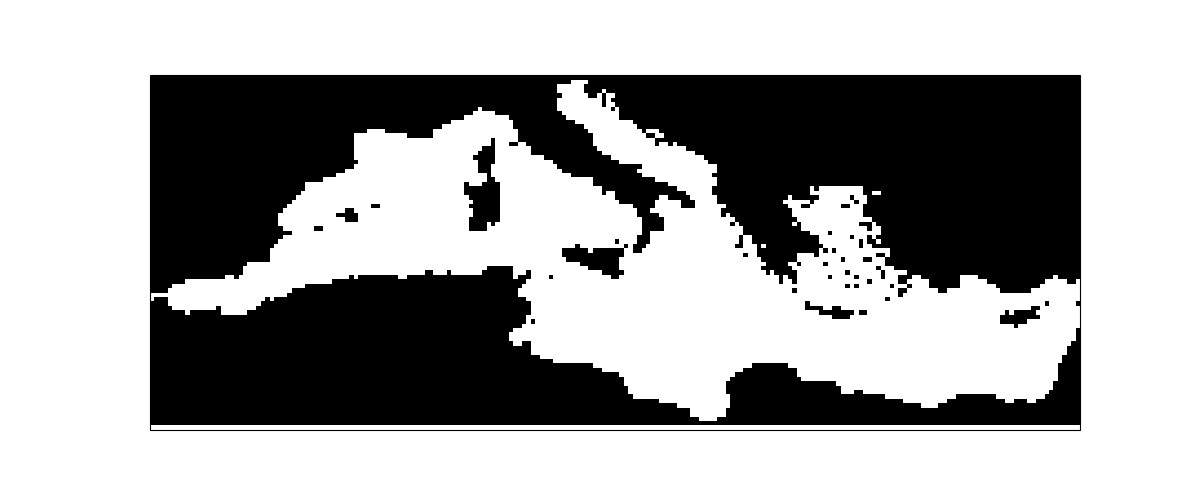

In [16]:
results.animate_particles()

/tmp/ipykernel_1710998/2510878519.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(results.likelihood))
/tmp/ipykernel_1710998/2510878519.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(results.analysis_X,results.analysis_Y,np.log10(results.input_coast))
/tmp/ipykernel_1710998/2510878519.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(results.analysis_X,results.analysis_Y,np.log10(results.input_coast))
/tmp/ipykernel_1710998/2510878519.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(results.input_rivers))
/tmp/ipykernel_1710998/2510878519.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.p

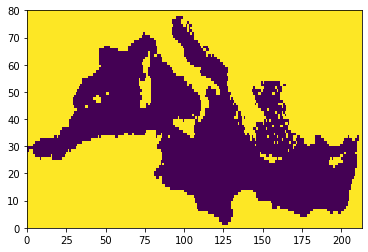

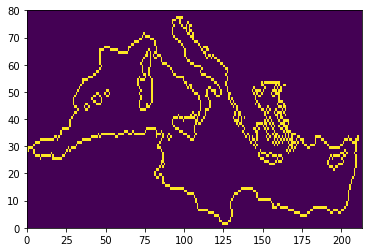

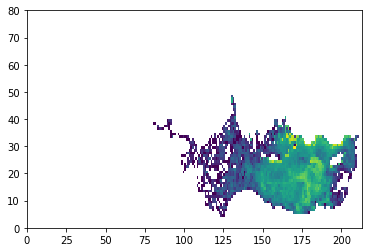

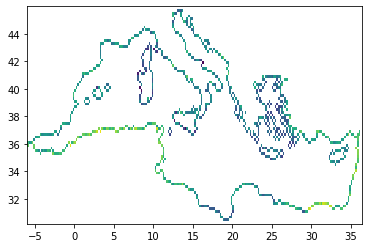

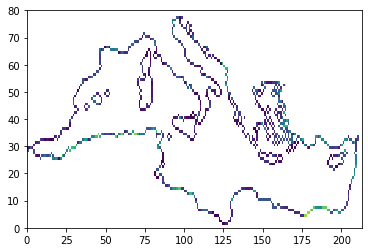

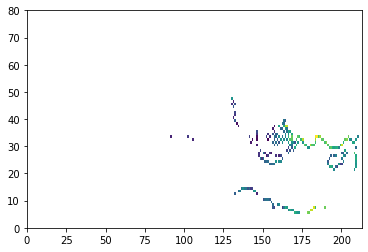

In [212]:
plt.figure()
plt.pcolormesh(results.analysis_landmask)

plt.figure()
plt.pcolormesh(results.analysis_coastmask)

plt.figure()
plt.pcolormesh(np.log10(results.likelihood))

plt.figure()
plt.pcolormesh(results.analysis_X,results.analysis_Y,np.log10(results.input_coast))

plt.figure()
plt.pcolormesh(np.log10(results.input_rivers))

plt.figure()
plt.pcolormesh(np.log10(results.posterior))

(30.99026870727539, 39.69648361206055)

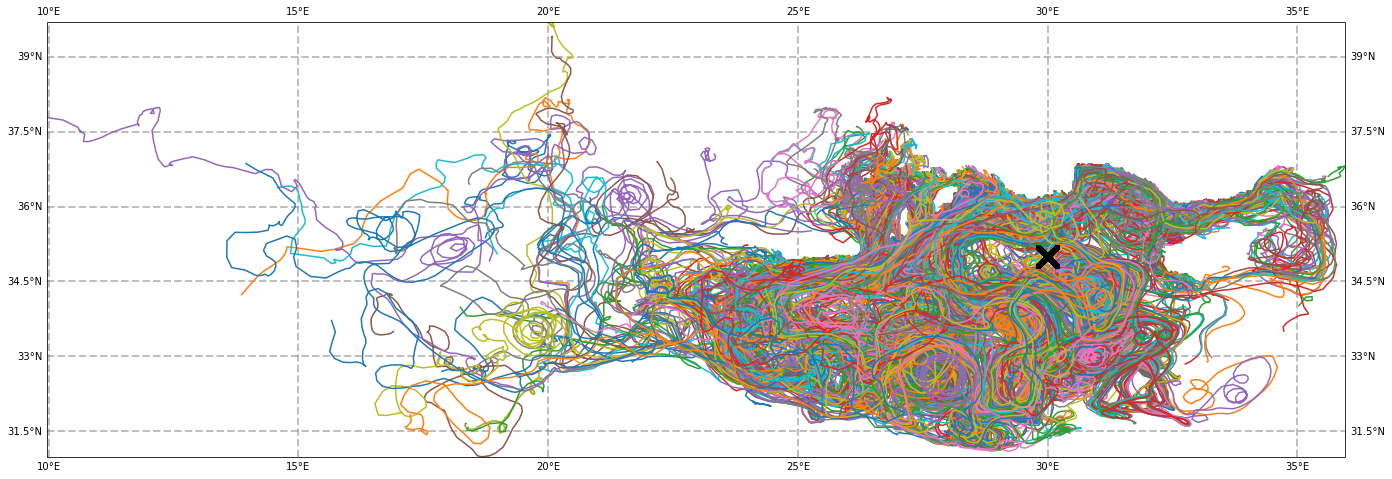

In [213]:
data_refined = results.data_refined


fig = plt.figure(figsize=(32,8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines(resolution='50m')
# ax.pcolormesh(X_land, Y_land, land_mask['mask_land'][:-1,:-1],cmap='Greys')

for i1 in range(len(data_refined['traj'])):
    ax.plot(data_refined['lon'][i1,:].values,data_refined['lat'][i1,:].values,'-')
# for i1 in range(len(data_refined['traj'])):
for i1 in range(1):
    ax.plot(data_refined['lon'][i1,0].values,data_refined['lat'][i1,0].values,'kx',markersize=20)
    
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_xlim(data_refined['lon'].min(),data_refined['lon'].max())
ax.set_ylim(data_refined['lat'].min(),data_refined['lat'].max())